In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [2]:
cumas = np.round([2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465], 3)
aras = np.round([1.0957813643749393e-17, 1.2060287427482614, 2.636411170614044, 4.633309896886311, 6.3697279021373925, 7.370992838892073], 3)

In [3]:
def parse_minutes(x):
    
    spl = x.split('.')[0].split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def read_map(P1, P2, induction_lvl=6, ctrl_replicate=2):
    
    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([None] * 12)
    plate_map_builder.append([None, None, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()

def generate_map(dictionary):
    
    sample_map = pd.Series(dictionary['short_name'].values, index=dictionary['id']).to_dict()
    sample_map.update({
        'BK': 'blank-kan',
        'BA': 'blank-amp',
        '3K3-N': 'negative-control-kan',
        '4A3-N': 'negative-control-amp',
        '4A3-P': 'positive-control-amp'
    })
    return sample_map

def generate_metadata(well, plate_map, sample_map):
    
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    return df.dropna()

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    #df['time'] = df['index']#.apply(parse_minutes)
    df = df.set_index('index')#.drop('index', axis=1)
    return df

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

In [4]:
folder = '033-all-and-gates-characterization'
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))
heatmaps = []

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    plate_map = read_map(P1, P2)
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    raw_data = pd.read_csv('datasets/experiment/{}/{}-{}.csv'.format(folder, a, b), skiprows=[0])
    sample_map = generate_map(pd.read_csv('datasets/dictionary.csv'))
    metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
    data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
    datas = generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))
    
    samples = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' not in x, datas[1].columns)],
                                 datas[0][filter(lambda x: '-amp' not in x, datas[0].columns)])
    reporter = get_neg_ctrl_corrected(datas[1][filter(lambda x: '-amp' in x, datas[1].columns)],
                                  datas[0][filter(lambda x: '-amp' in x, datas[0].columns)])
    
    samples_t = samples.mean()
    
    fluo = samples_t[filter(lambda x: x.startswith(sample_map[P1]), samples_t.index)]
    fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
    fluo_t['cuma'] = fluo_t['gate'].str[-2]
    fluo_t['ara'] = fluo_t['gate'].str[-1]
    fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
    fluo_pvt.index = cumas
    fluo_pvt.columns = aras
    heatmaps.append((sample_map[P1], fluo_pvt/np.mean(reporter.values)))
    
    fluo = samples_t[filter(lambda x: x.startswith(sample_map[P2]), samples_t.index)]
    fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
    fluo_t['cuma'] = fluo_t['gate'].str[-2]
    fluo_t['ara'] = fluo_t['gate'].str[-1]
    fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
    fluo_pvt.index = cumas
    fluo_pvt.columns = aras
    heatmaps.append((sample_map[P2], fluo_pvt/np.mean(reporter.values)))

100%|██████████| 19/19 [00:01<00:00, 12.57it/s]


In [5]:
def plot_heatmap(heatmaps):
    
    f, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(18, 6))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(heatmaps):
            sns.heatmap(heatmaps[i][1], annot=True, fmt='.2f', cmap='cividis', ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(heatmaps[i][0])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

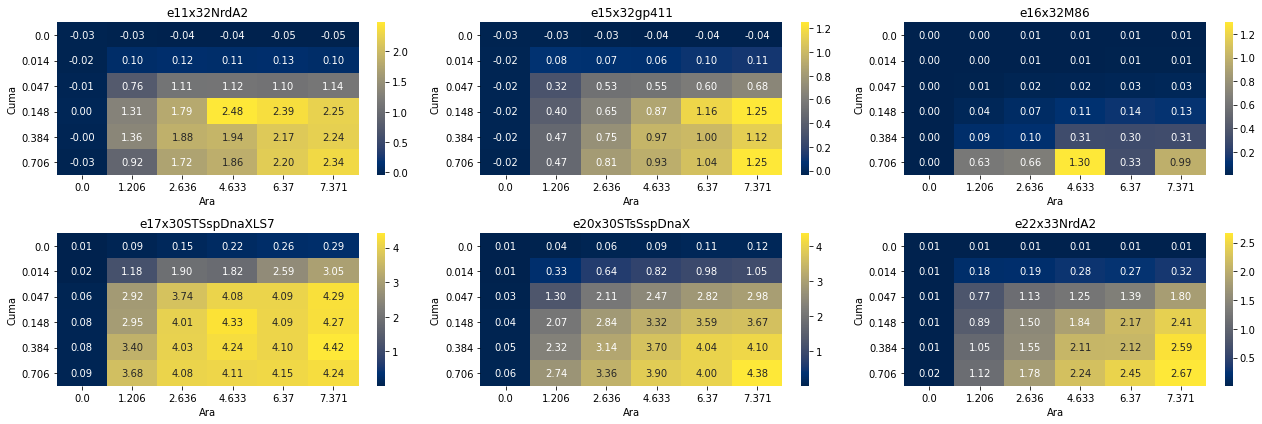

In [6]:
plot_heatmap(heatmaps[0:6])

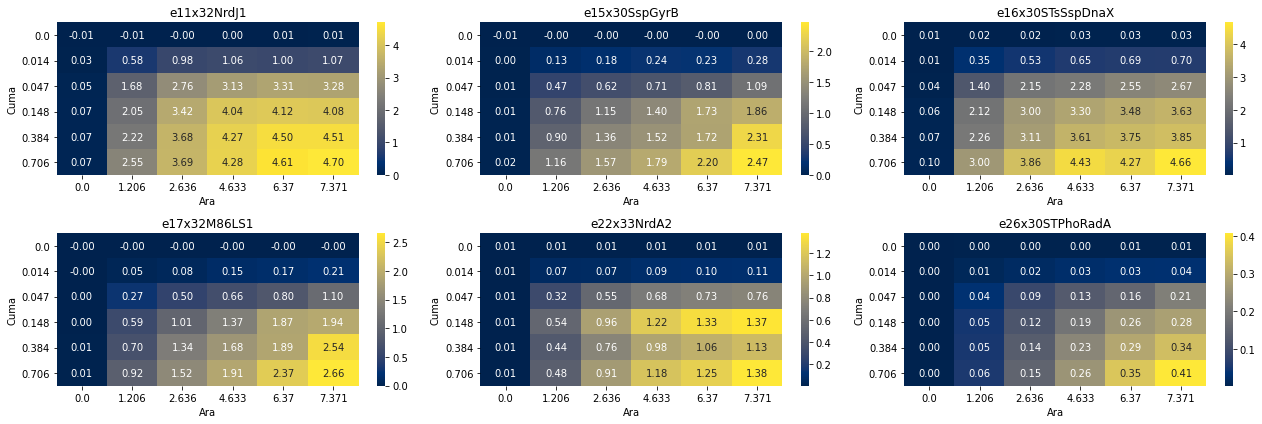

In [7]:
plot_heatmap(heatmaps[6:12])

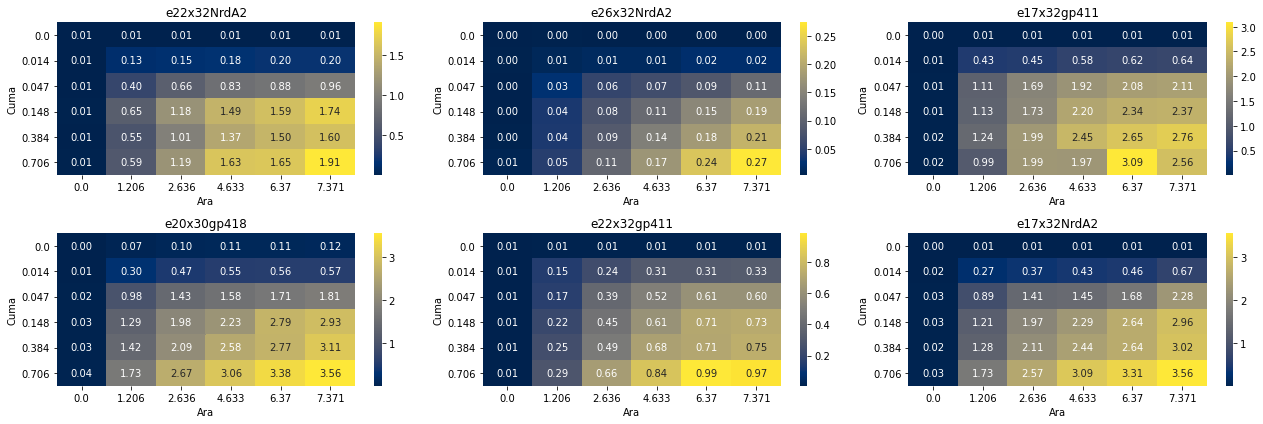

In [8]:
plot_heatmap(heatmaps[12:18])

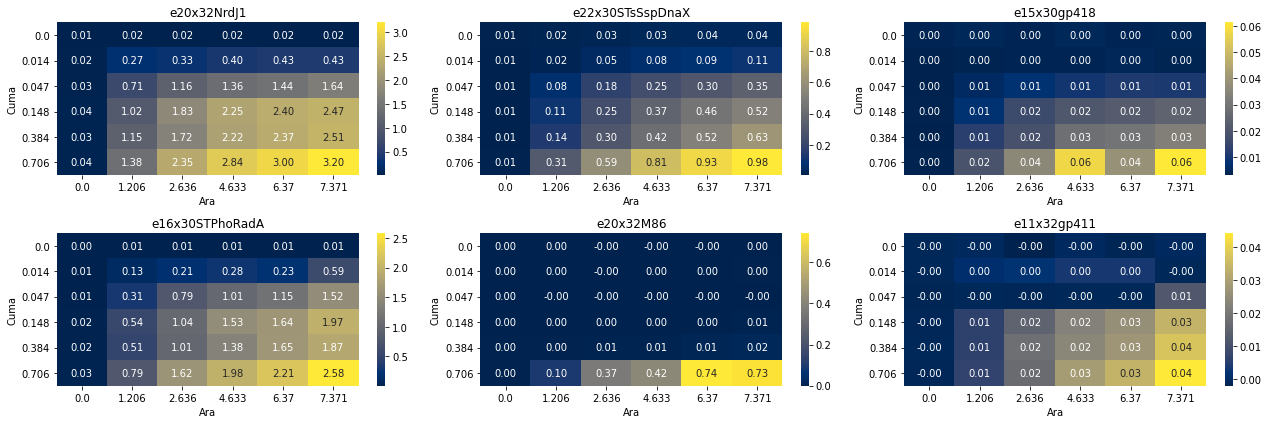

In [9]:
plot_heatmap(heatmaps[18:24])

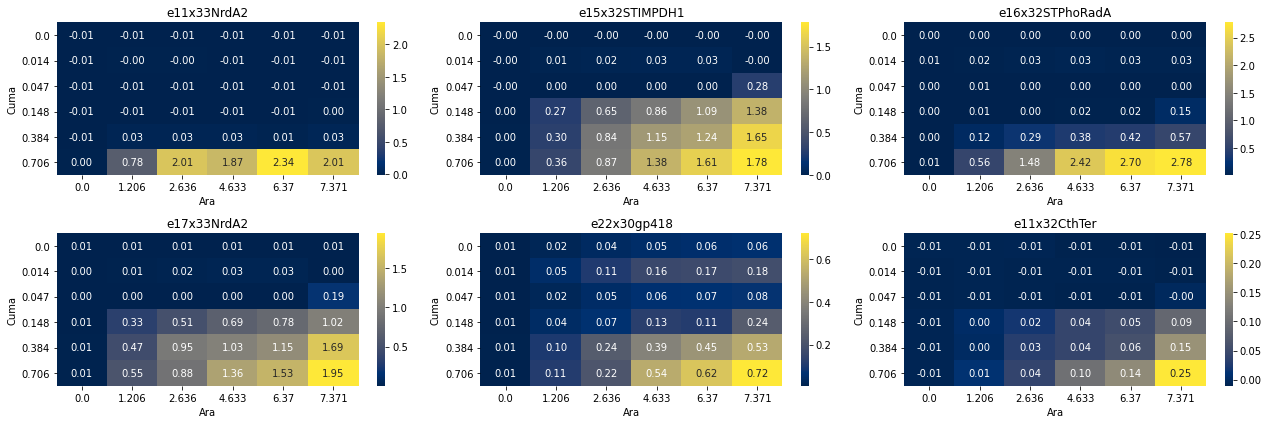

In [10]:
plot_heatmap(heatmaps[24:30])

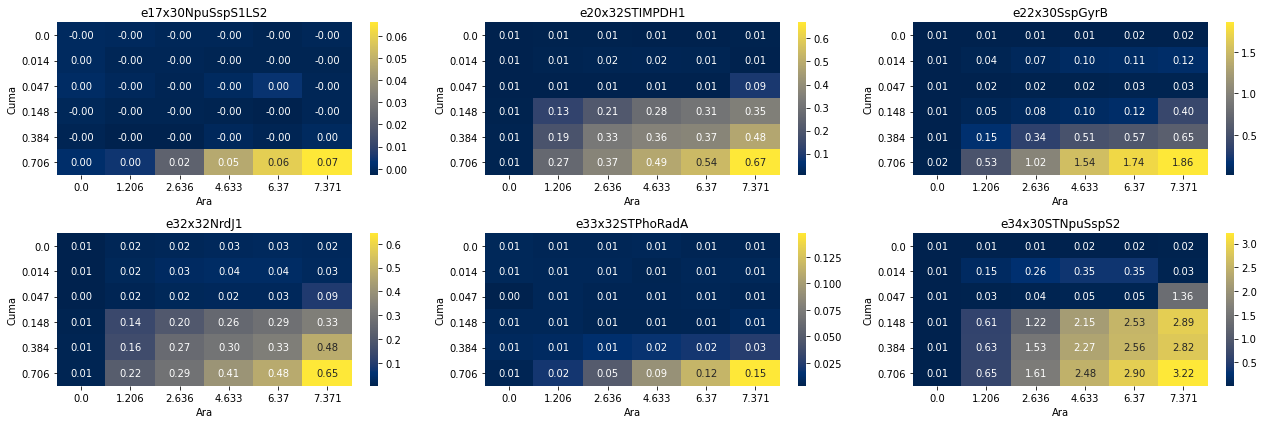

In [11]:
plot_heatmap(heatmaps[30:36])

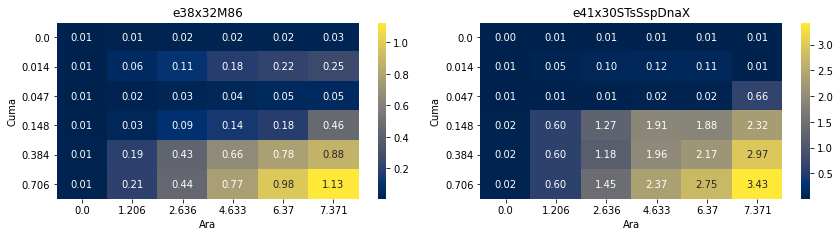

In [12]:
plot_heatmap(heatmaps[36:42])

In [13]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    popt, _ = curve_fit(func, ts, data, p0=p0, bounds=bounds)
    sim = hill_activation_and(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

#complete
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

In [29]:
hill_params= []
ys = []
colormeshes = []

for i in tqdm(range(len(heatmaps))):
    
    fluo = heatmaps[i][1]
    fluo = fluo.reset_index().melt('index', var_name='ara', value_name='fluo')
    fluo.rename(columns={'index': 'cuma'}, inplace=True)

    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    y = np.abs(fluo['fluo'].values)
    
    gate_bounds = [[0, 0, 0, 0, 0, 0, 0, 0],
                   [1e3, 1e3, 4, 4, y.min()+0.1, y.min()+0.1, y.max()+0.5*y.max(), y.max()+0.5*y.max()]]

    init_guess = randomSearch(10, x, y, gate_bounds, hill_activation_and)
    popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)

    y_pred = hill_activation_and(x, *popt)
    hill_params.append((heatmaps[i][0], *popt))
    
    ys.append((heatmaps[i][0], y, y_pred))

    arr_ind1 = np.arange(0, np.max(cumas), 0.005)
    arr_ind2 = np.arange(0, np.max(aras), 0.05)
    x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
    x_ = np.vstack((x1_.ravel(), x2_.ravel()))
    y_pred_ = hill_activation_and(x_, *popt)
    
    colormeshes.append((x2_, x1_, y_pred_, len(arr_ind1), heatmaps[i][0]))

100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


In [30]:
def plot_colormesh(colormeshes):
    
    f, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(18, 6))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(colormeshes):
            cf = ax.pcolormesh(colormeshes[i][0], colormeshes[i][1],
                               colormeshes[i][2].reshape(-1, colormeshes[i][3]), cmap='viridis')
            f.colorbar(cf, ax=ax)
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(colormeshes[i][4])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

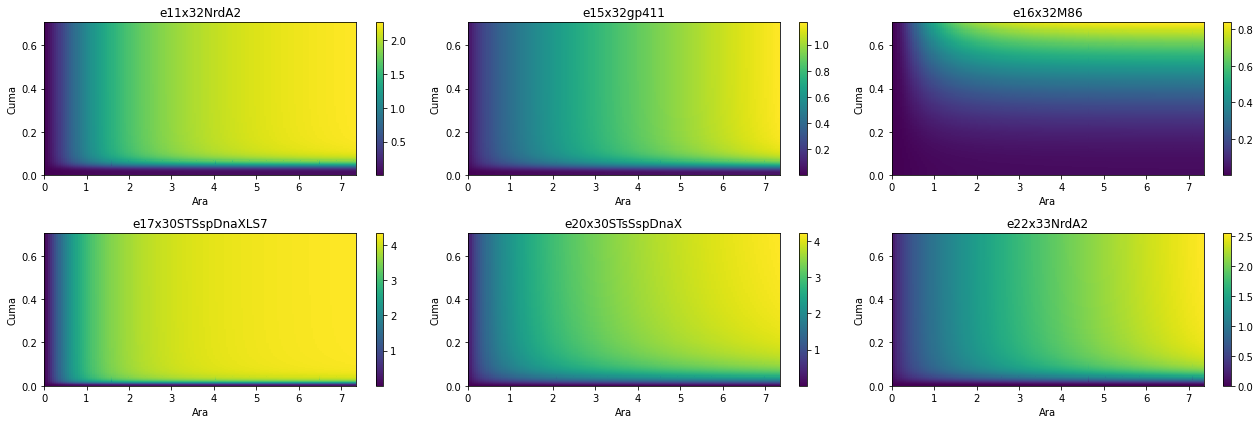

In [31]:
plot_colormesh(colormeshes[0:6])

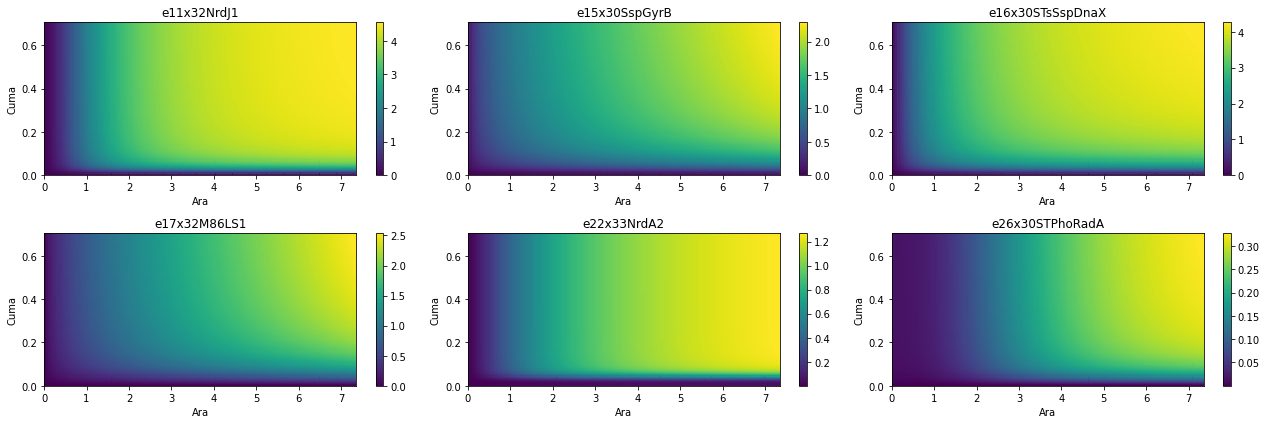

In [32]:
plot_colormesh(colormeshes[6:12])

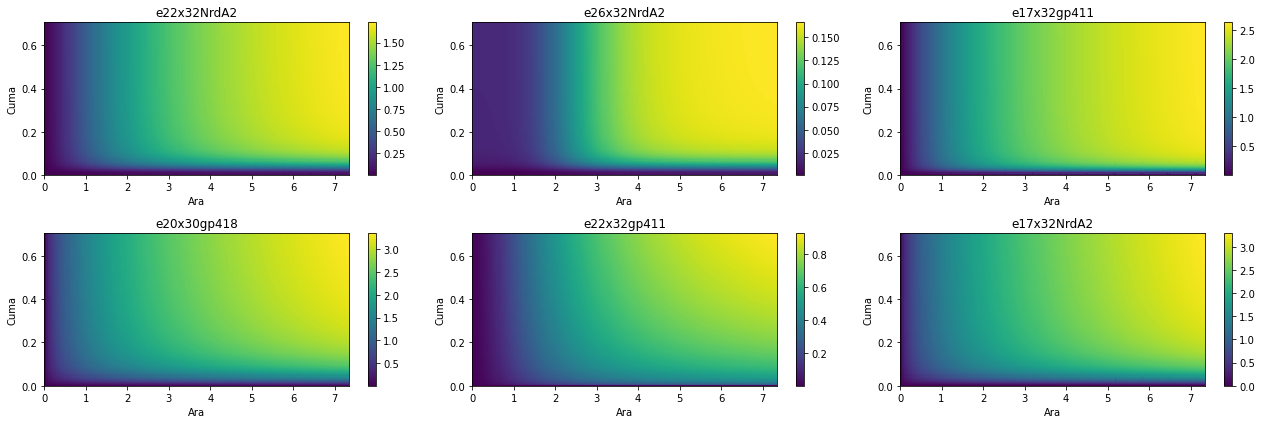

In [33]:
plot_colormesh(colormeshes[12:18])

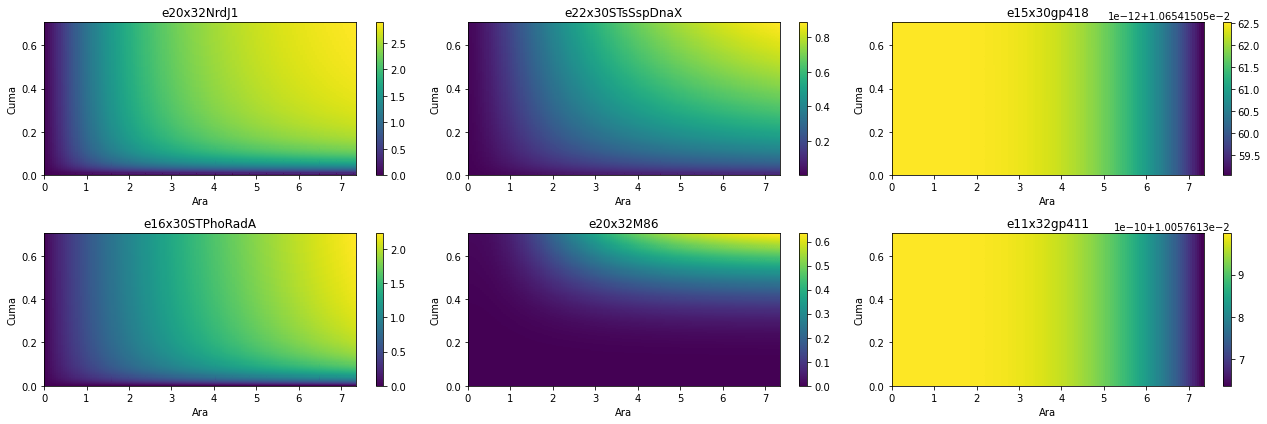

In [34]:
plot_colormesh(colormeshes[18:24])

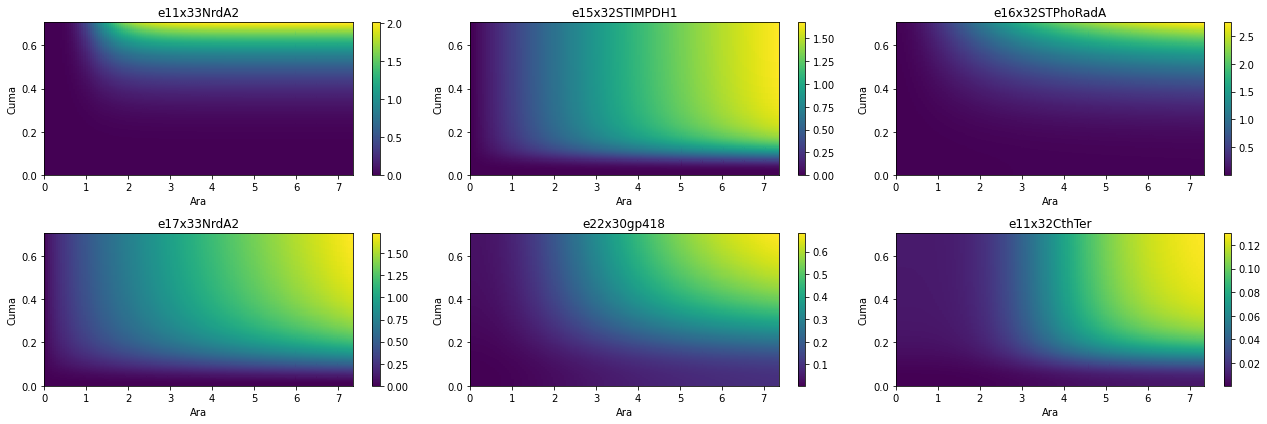

In [35]:
plot_colormesh(colormeshes[24:30])

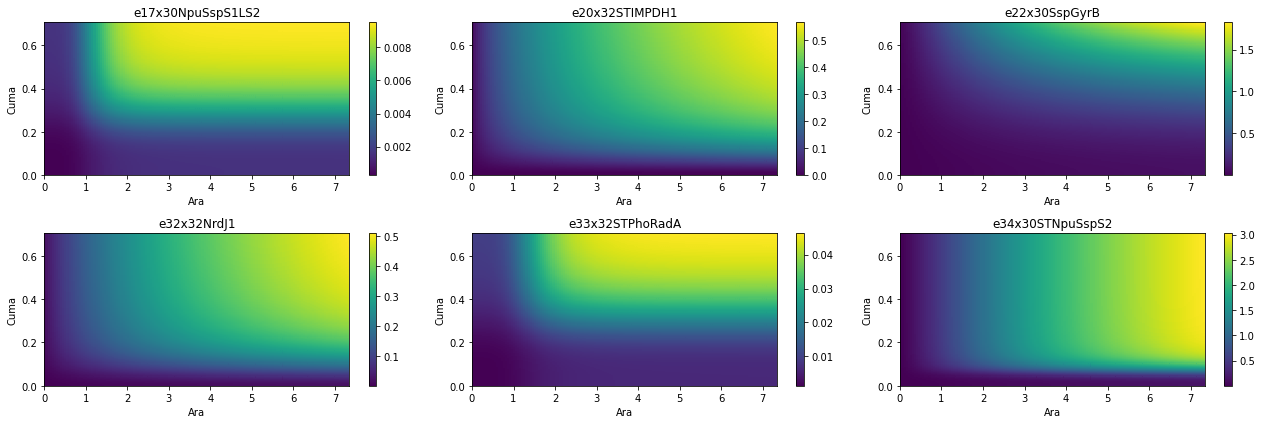

In [36]:
plot_colormesh(colormeshes[30:36])

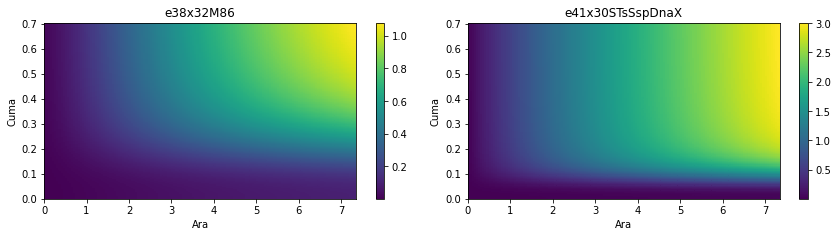

In [37]:
plot_colormesh(colormeshes[36:42])

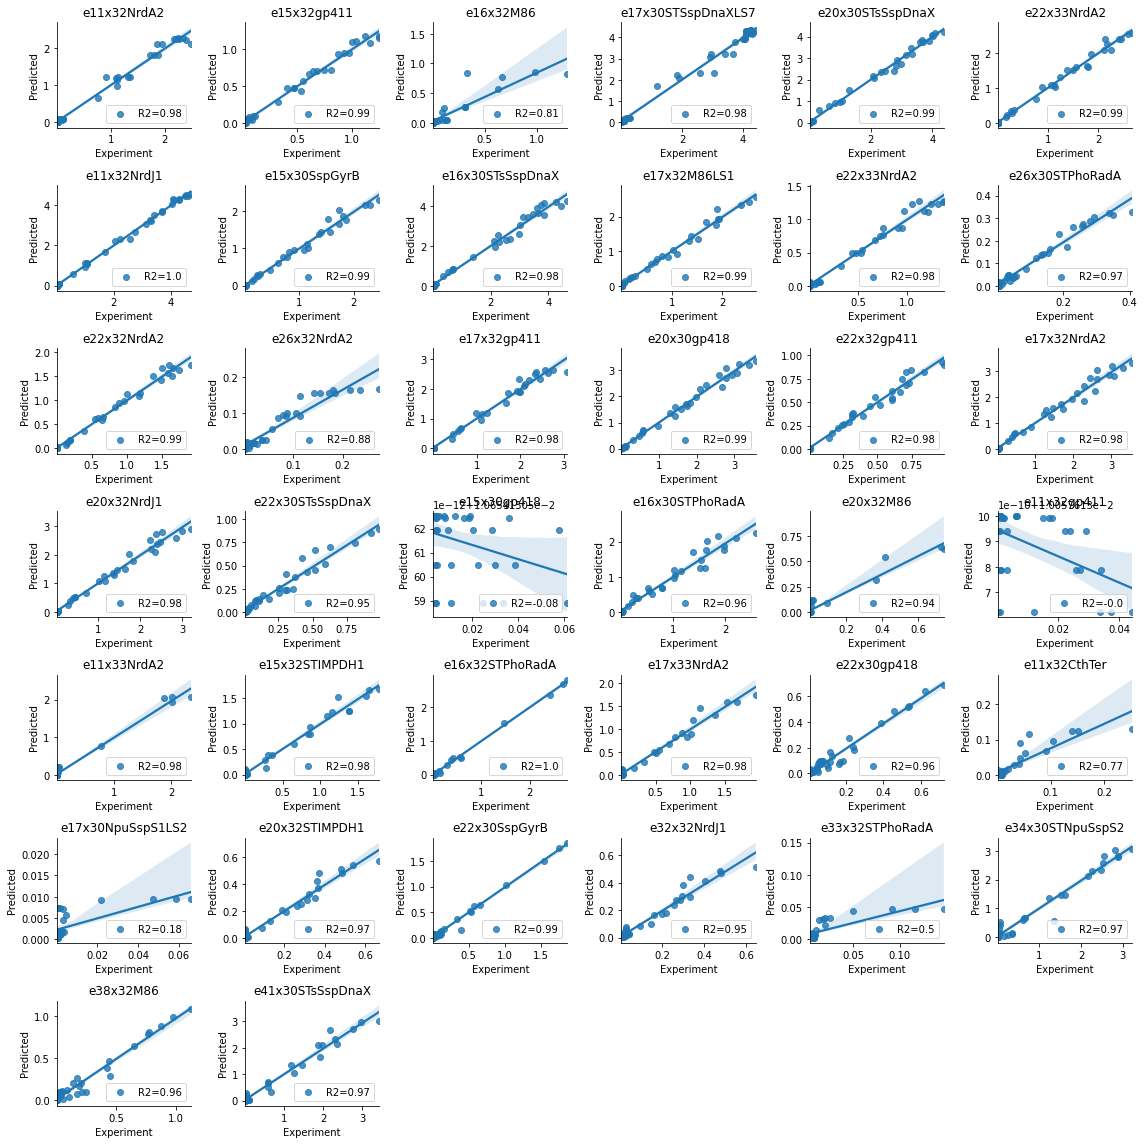

In [38]:
f, axs = plt.subplots(7, 6, sharex=False, sharey=False, figsize=(16, 16))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(ys):
        sns.regplot(ys[i][1], ys[i][2], ax=ax, label='R2={}'.format(round(r2_score(ys[i][1], ys[i][2]), 2)))
        ax.set_title(ys[i][0])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [39]:
params = pd.DataFrame(hill_params, columns=['gate','K1','K2','n1','n2','ymin1','ymin2','ymax1','ymax2']) \
            .set_index('gate')
params.head()

,K1,K2,n1,n2,ymin1,ymin2,ymax1,ymax2
gate,,,,,,,,
e11x32NrdA2,0.046126,1.240959,4.000000,1.349944,0.047059,0.009625,1.349979,1.830990
e15x32gp411,0.042365,21.563856,2.990761,0.659098,0.086473,0.012092,1.874720,1.874720
e16x32M86,1.213186,0.836146,2.306475,1.838218,0.013458,0.010546,1.947345,1.947345
e17x30STSspDnaXLS7,0.013789,0.626612,2.447816,1.377079,0.052334,0.074533,1.010069,4.437398
e20x30STsSspDnaX,0.033019,2.397162,1.463270,0.686358,0.040549,0.022620,2.339913,2.665031


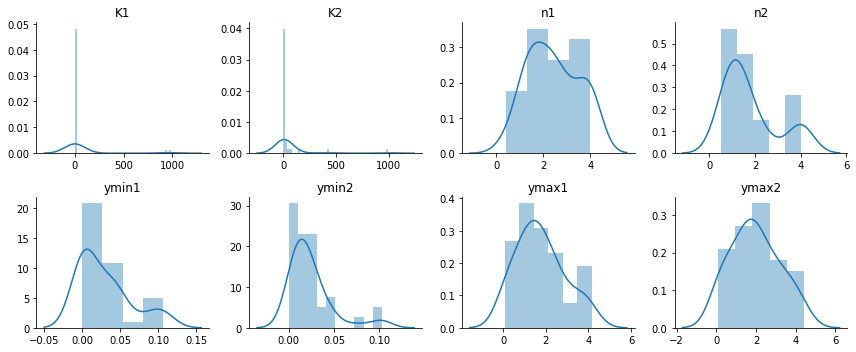

In [40]:
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < params.shape[1]:
        sns.distplot(params.iloc[:,i], ax=ax)
        ax.set_title(params.columns[i])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        #ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()